In [138]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import plotly.express as px
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from torch.optim.lr_scheduler import ExponentialLR


import time


In [139]:
df = pd.read_csv("../data/tesla_stock.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1692 entries, 0 to 1691
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1692 non-null   object 
 1   Open       1692 non-null   float64
 2   High       1692 non-null   float64
 3   Low        1692 non-null   float64
 4   Close      1692 non-null   float64
 5   Volume     1692 non-null   int64  
 6   Adj Close  1692 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 92.7+ KB


In [140]:
X = df.get('Close').values
scaler = StandardScaler()
X = scaler.fit_transform(X.reshape((-1,1 ))).reshape((-1))

split_index = 1400
print(X.shape)
X_train, X_test = X[:split_index], X[split_index:] #train_test_split(X, test_size=0.1, shuffle=False)
timesteps_count = 30
pred_count = 3

def get_train_test():
    x_train, y_train, x_test, y_test = [], [], [], []

    i = 0
    while i+timesteps_count<len(X_train)-pred_count:
        x_train.append(np.expand_dims(X_train[i:i+timesteps_count],-1))
        y_train.append(X_train[i+timesteps_count+pred_count])
        i+=1

    i=0
    while i+timesteps_count<len(X_test)-pred_count:
        x_test.append(np.expand_dims(X_test[i:i+timesteps_count],-1))
        
        y_test.append(X_test[i+timesteps_count+pred_count])

        i+=1
        
    x_train, y_train = torch.tensor(np.array(x_train), dtype=torch.float), torch.tensor(np.array(y_train), dtype=torch.float)
    x_test, y_test = torch.tensor(np.array(x_test), dtype=torch.float), torch.tensor(np.array(y_test), dtype=torch.float)
    return x_train, y_train, x_test, y_test
x_train, y_train, x_test, y_test = get_train_test()
print(x_train.shape, y_train.shape)

(1692,)
torch.Size([1367, 30, 1]) torch.Size([1367])


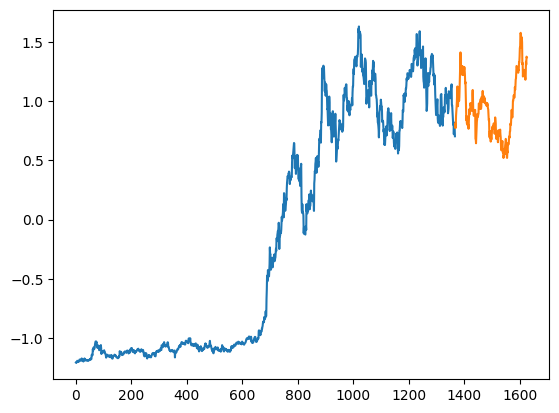

In [141]:
plt.plot(y_train)
plt.plot(np.arange(len(y_train), len(y_train)+len(y_test)), y_test)

## Develop an LSTM network

In [142]:
MAX_TIME = 300
n_layers = 3

hidden_dim = 2

In [143]:
class LSTMPredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_layers):

        super(LSTMPredictor, self).__init__()
        self.hidden_dim = hidden_dim
        self.input_dim = input_dim

        self.lstm1 = nn.LSTM(input_dim, hidden_dim, num_layers=n_layers, batch_first=True)

        self.linear1 = nn.Linear(hidden_dim, 1)

        self.n_layers = n_layers

    def forward(self, x):
        BATCH_SIZE = x.shape[0]
        hidden_state = torch.zeros((self.n_layers, BATCH_SIZE, self.hidden_dim))
        cell_state = torch.zeros((self.n_layers, BATCH_SIZE, self.hidden_dim))
        initial_state = (hidden_state, cell_state)
        out = x
        if len(x.shape)==2:
            out = x.unsqueeze(-1)
        out,state_out = self.lstm1(out, initial_state)
        out = self.linear1(out[:, -1])
        #out = self.linear2(out)
        out = out.view((-1, ))
        return out


class LinearPredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim):

        super(LinearPredictor, self).__init__()
        self.hidden_dim = hidden_dim
        self.input_dim = input_dim
        self.linear1 = nn.Linear(input_dim, 1)
        #self.linear2 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out = x
       
        out = self.linear1(out)
        #out = nn.ReLU()(out)
        #out = self.linear2(out)
        out = out.view((-1, ))
        return out




 93%|█████████▎| 278/300 [05:00<00:23,  1.08s/it]


Text(0.5, 1.0, 'Train')

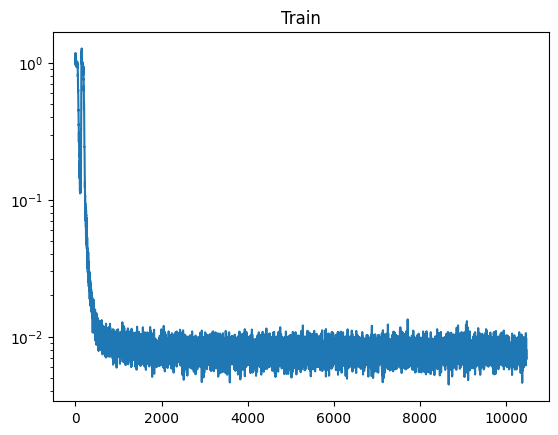

In [144]:


model = LSTMPredictor(1, hidden_dim = hidden_dim, n_layers=n_layers)
#model = LinearPredictor(x_train.shape[1], hidden_dim = 60)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = ExponentialLR(optimizer, gamma=0.999)
EPOCHS = 10
BATCH_SIZE = 256
N = x_train.shape[0]
losses_adam = []
t0 = time.time()
t1 = time.time()



with tqdm(total=MAX_TIME) as pbar:
    while time.time()<t0+MAX_TIME:
        if time.time()>t1+1:
            t1 = time.time()
            pbar.update()
        
        indices = np.arange(len(x_train))
        np.random.shuffle(indices)
        x_train = x_train[indices]
        y_train = y_train[indices]
        #print(indices.shape)
        for i in range(N//BATCH_SIZE+1):
            model.zero_grad()
            batch_x = x_train[i*BATCH_SIZE: (i+1)*BATCH_SIZE]
            batch_y = y_train[i*BATCH_SIZE: (i+1)*BATCH_SIZE]
            if len(batch_x)<BATCH_SIZE:
                continue
            output = model(batch_x)
            loss = loss_fn(output, batch_y)
            loss.backward()
            optimizer.step()

            losses_adam.append(loss.detach().numpy())
        scheduler.step

 
plt.semilogy(losses_adam)
plt.title("Train")

[22.3402141  22.15253384 21.94181222 21.77822985 21.67772458 21.63310303
 21.60104745 21.57557832 21.57094757 21.62721344 21.66605779 21.71964861
 21.77389133 21.81810825 21.86234765 21.88365809 21.93956429 22.04544212
 22.16527964 22.24998191] [18.77999889 19.14999808 18.76999557 18.79000221 19.10000396 20.12999747
 19.20000344 19.89999979 19.74999495 19.70000083 19.87000107 19.47999524
 20.45000254 21.06000273 21.04999941 20.5399987  20.89999457 20.70999894
 20.1699995  20.72000226]
tensor(99.0933, dtype=torch.float64)
(1367,) (1367,)
tensor(99.0933, dtype=torch.float64)


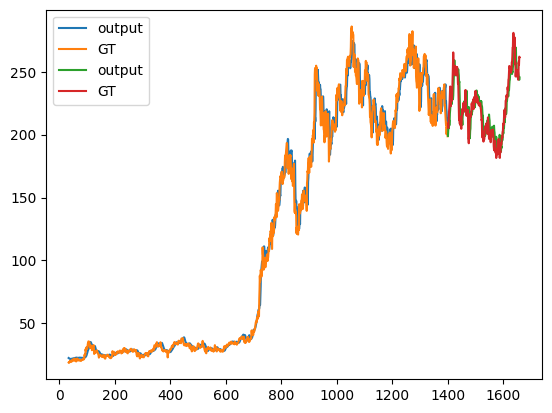

In [145]:
def test(model):
    with torch.no_grad():
        
        output = model(x_test)
        unscaled_output = scaler.inverse_transform(output.reshape((-1, 1))).reshape((-1, ))
        unscaled_y_test = scaler.inverse_transform(y_test.reshape((-1, 1))).reshape((-1,))

        output = model(x_train)

        unscaled_output_train = scaler.inverse_transform(output.reshape((-1, 1))).reshape((-1, ))
        unscaled_y_train = scaler.inverse_transform(y_train.reshape((-1, 1))).reshape((-1,))
        print(unscaled_output_train[:20], unscaled_y_train[:20])

        loss = loss_fn(torch.tensor(unscaled_output),torch.tensor(unscaled_y_test ))
        print(loss)
        plt.figure()
        print(unscaled_output_train.shape, unscaled_y_train.shape)
        plt.plot(np.arange(timesteps_count+pred_count, split_index), unscaled_output_train, label="output")
        plt.plot(np.arange(timesteps_count+pred_count, split_index), unscaled_y_train, label="GT")
        plt.plot(np.arange(split_index, split_index+len(x_test)), unscaled_output, label="output")
        plt.plot(np.arange(split_index, split_index+len(x_test)), unscaled_y_test, label="GT")
        plt.legend()
        print(loss)
x_train, y_train, x_test, y_test = get_train_test()

test(model)


## Predicting with moving average

In [146]:
window_size = 50
df["MA"] = df["Close"].rolling(window_size).mean()

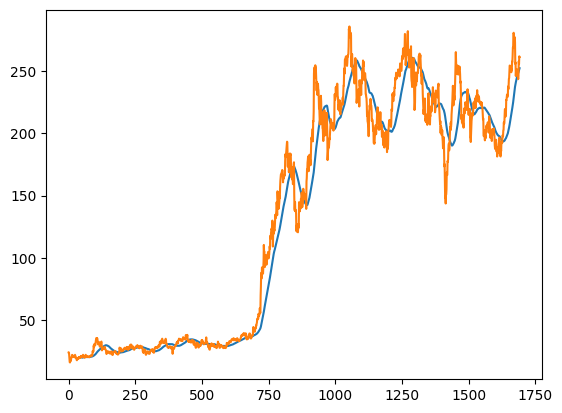

In [147]:
plt.plot(df["MA"])
plt.plot(df["Close"])

## Prediction with exponential average

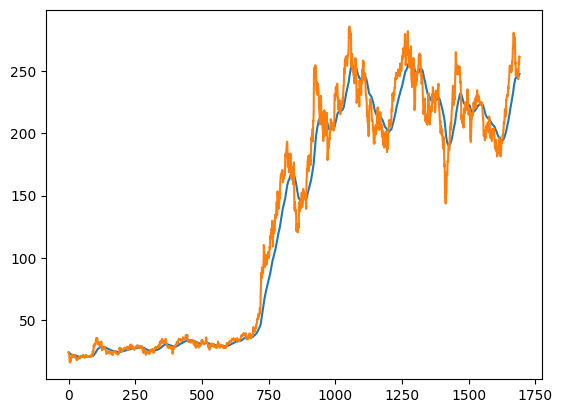

In [148]:
df["EA"] = df["Close"].ewm(span=window_size, adjust=False).mean()
plt.plot(df["EA"])
plt.plot(df["Close"])


In [149]:
%load_ext autoreload
%autoreload 2

from functions.PyTorchGN import NN_GN
from algorithms.algo2 import optimize

x_train, y_train, x_test, y_test = get_train_test()

y_train = y_train.reshape((-1, 1)).detach().numpy()
x_train = x_train.detach().numpy()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


(1367, 30, 1) (1367, 1) (139,)
Parameter count 139
25
0
Train error:  0.9897071598390637 lambd:  1.0
Epoch time:  4.180722236633301
0
0
29
Train error:  0.7360592488398409 lambd:  0.25
Epoch time:  4.219834327697754
0
23
0
Train error:  0.06514207551142728 lambd:  0.0625
Epoch time:  3.3838446140289307
3
0
0
Train error:  0.008452589178748086 lambd:  0.015625
Epoch time:  6.898316383361816
0
8
Max back track
Train error:  0.007907332341515765 lambd:  0.0625
Epoch time:  7.476881980895996
0
20
9
Train error:  0.007832710640048493 lambd:  0.25
Epoch time:  6.821128845214844
0
11
8
Train error:  0.007751385312753606 lambd:  1.0
Epoch time:  6.72274374961853
6
Max back track
Max back track
Train error:  0.007750015844806931 lambd:  16.0
Epoch time:  7.345075368881226
0
0
Max back track
Train error:  0.007699012756347656 lambd:  4.0
Epoch time:  7.306797027587891
0
12
21
Train error:  0.007695825237729032 lambd:  16.0
Epoch time:  7.164477825164795
14
Max back track
17
Train error:  0.00769

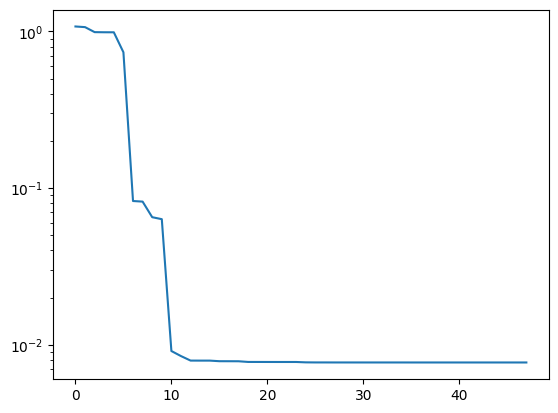

In [150]:
model = LSTMPredictor(1, hidden_dim = hidden_dim, n_layers=n_layers)


#model = LinearPredictor(input_dim, hidden_dim)
nn_gn = NN_GN(model, is_linear=False)
X0 = nn_gn.get_X()


print(x_train.shape, y_train.shape, X0.shape)
## Do Gauss Newton

X_est,losses_gn, _, _, _ = optimize(nn_gn, X0, x_train, y_train, batch_size=270 ,
max_time=MAX_TIME,optimization_method="Random", optim_params={"keep_prob": 0.1, "max_backtrack": 50}, backtrack=True)

print(np.linalg.norm(X_est-X0))

plt.semilogy(losses_gn)

[19.02076418 18.19021889 17.5776111  17.64678012 17.97158454 18.3485411
 18.34887829 18.32977082 18.47961831 19.10611835 18.98129041 19.22289868
 19.29908127 19.29950837 19.38324403 19.23036183 19.63959877 20.21302502
 20.51294478 20.37854062] [18.77999889 19.14999808 18.76999557 18.79000221 19.10000396 20.12999747
 19.20000344 19.89999979 19.74999495 19.70000083 19.87000107 19.47999524
 20.45000254 21.06000273 21.04999941 20.5399987  20.89999457 20.70999894
 20.1699995  20.72000226]
tensor(98.8264, dtype=torch.float64)
(1367,) (1367,)
tensor(98.8264, dtype=torch.float64)


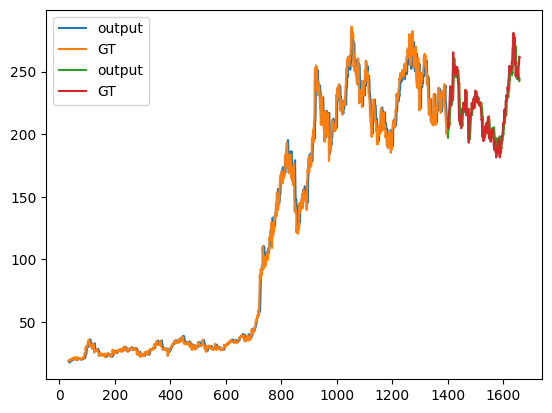

In [151]:
x_train, y_train, x_test, y_test = get_train_test()


test(model)

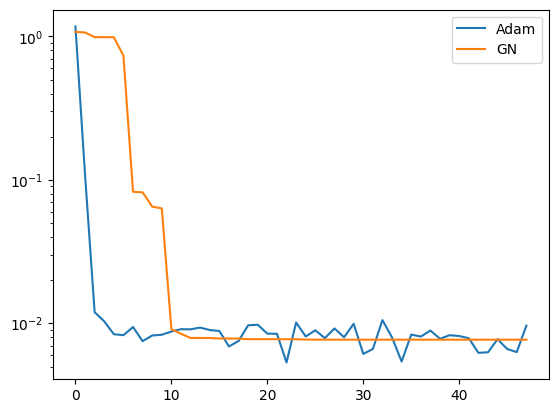

In [152]:
idx = np.round(np.linspace(0, len(losses_adam) - 1, len(losses_gn))).astype(int)
plt.semilogy(np.array(losses_adam)[idx], label="Adam")
plt.semilogy(losses_gn, label="GN")
plt.legend()